# Gradients

Refs:
* Book: Elements of Statistical Learning
* https://www.deeplearningbook.org/  <== This is a goodreference for Deep Learning
* math demonstrations:
    * https://stats.stackexchange.com/questions/278771/how-is-the-cost-function-from-logistic-regression-derivated/278812 
    * https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d
    * https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
* Explanations and equations about momentum and others optmizers:
    * https://vzahorui.net/optimization/gradient-descent/
    
* Vidsual animations: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c
* Learning Rate finder
    * https://miguel-data-sc.github.io/2017-11-05-first/
    * https://arxiv.org/pdf/1506.01186.pdf

This notebook reviews some central concepts in deep learning and implements the three main gradient descent algorithms using the NumPy library for linear regression and logistic regression. Latter, we introduce momentum and learning rate scheduler. While presenting the algorithms, we will be doing brief discussions about the impact of initialization, learning rate and outliers in the data (Gradient Vanish).
 
 
**TODO**: Review and write it better Add motivations of each algo


* Gradient descent: 
    * Precise
    * Computational slow
    * Resource hungry 
    * Numerical convergence slow because 1 update per epcoh
    
* Stochastic:
    * Gradients is not precise. 
    * Do not consuming too much resource 
    * Lack of parrellism
    *  Do not use too many rsources
    * Faster numerical convergence. $n$ updates per eoch where $n$ is the train dataset
 
 * Mini batch
     * Gradients more precise than Stochastic 
     * Computational fast because can expore parralellism 
     * Fast neumerical convergence becuase teher are many updates per epcoh
     * Do not use too many rsources
 
--------
Terms used in deep learning:

* epoch: one pass over the entire data
* 1 step: update the parameters
* B: mini-batch size

ref: https://towardsdatascience.com/learning-parameters-part-3-ee8558f65dd7

| Gradient Algo                     | #steps in epoch |
|-----------------------------------|-----------------|
| Vanilla or Batch Gradient Descent | 1               |
| Stochastic Gradient Descent       | N               |
| Mini Batch Gradient Descent       | N/B             |



Analogy with Gravity:

* Potential Energy => Loss Function
* Goal Minimize Potential Energy => Minimize Loss Function 
* Mountain (x,y,z) => Regression Coefficient ($\theta$)
* modify (x,y) to archive the goal => modify $\theta$ to achive the goal
* Bottom of the Bowl or mountain => Minimum Value of Loss (Error)


In [3]:
import numpy as np
import random as rand

import matplotlib
import matplotlib.pyplot as plt
# required for iteractive plot
%matplotlib notebook  

import seaborn as sns
from scipy import stats 

from sklearn.datasets import make_classification, make_blobs, make_regression
from sklearn.metrics import accuracy_score

from typing import List, Set, Dict, Tuple, Optional, Union, Callable

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Cost, Loss and hypothesis function


The terms **cost** and **loss** are many time used interchancheble by many authors (Ian Goodfellow, Yoshua Bengio, Aaron Courville ), other authors preffer to make a clear distinguish between them. Here we decide define this concepts and the concept of hypothesis in machine learning using the ref: https://stats.stackexchange.com/questions/179026/objective-function-cost-function-loss-function-are-they-the-same-thing .

* Hypothesis function $h_{\theta}(x, y)$
    1. It is the fucntional responsiple to do the mapping: (x -> y). It is the model you pick that you believe is the best to solve the task. 
    1. Ex in the context of Machine learning: linear regression, logistic regression and support vector machine all they have different $h_{\theta}(x, y)$. You neeed to determine the best by try and fail
    1. Ex context of deep learning: It is the different architecture you are tryng


* Loss function $\mathcal{L}(h_{\theta}(x^{(i)}), y_i)$
    1. It is the penality the algorithms pays by predicting $\hat{y}_i = h_{\theta}(x^{(i)}, y_i)$
        * if the estimation (prediction) is right $\hat{y}_i$, the penality should be zero
        * if the estimation (prediction) is wrong, the penality should increase with the difference between $\hat{y}_i$ and $y_i$
     1. It is a fucntion of data and not parameters. The parameters are assumed given and constant
     1. Examples of loss functions: Linear regression
     
$$
\mathcal{L}(x,y) =  \frac{1}{2} \left ( x \theta_1 + \theta_0 - y \right )^2 \\
h_{\theta_0,\theta_1}(x, y) = \left ( x \theta_1 + \theta_0 - y \right )^2
$$
     

* Cost function $J(\theta)$ 
    1. It is a function only of parameters. Data $x^{(i)},y_i$ are assumed as given and constant
    1. It is the average of the loss function over the dataset
    1. It means the average cost (penality) the algo paid for there mistakes over data sets or the complete batch
    
$$
J(\theta) = \frac{1}{n} \sum_{i=1}^n \mathcal{L}(h_{\theta}(x^{(i)}), y_i)
$$

## Gradient descent


In machine learning we define the loss fucntion $L = L(y, h_{\theta}(X))$. This function is reponsible  for penalizing mistakes. The machine learning algorithm learns by minimizing this function. $\theta$ are the paremeters of the models, $X$ is the trainning data, and $y$ are the labels. The term $h_{\theta}(X)$ is the hypothesis.  We define the cost function $J(\theta) = \frac{1}{n} \sum_{i=1}^n \mathcal{L}(h_{\theta}(x^{(i)}), y_i)$. Notices that the cost function $J(\theta)$ depends of the trainning data $X$, $y$ as well, but is considered only a function of the parameters $\theta$. Bellow is the cost function for Multiple Linear Regression:

$
J(\theta) =  \frac{1}{2n} \left ( X \theta - y \right )^t\left ( X \theta - y \right )
$

where $h_{\theta}(X) = X \theta$.

From calculus, 

$
d J(\theta) = \nabla_{\theta} J(\theta) * d\theta
$

where $*$ is the scalar product. Because the $cos(a)$ function is maximum when $a=0$ - $a$ is the angle between $\nabla_{\theta} J(\theta)$ and $d\theta$, therefore $\nabla_{\theta} J(\theta)$ and $d\theta$ are aligned - we know that the opposite direction of the gradient point to the direction that minimizes the cost function $J(\theta)$.

>PS: The opposite direction $\nabla_{\theta}J(\theta)$ minimizes the cost function. The gradient is a compass that instead of pointing North, is always pointing downhill.


The algorithm is summarized as follow:
    
1. Start from a random point $\theta = \theta_0$

1. Repeat the steps

    1. update direction (find the direction to minimize $J(\theta)$): $\Delta \theta = -\eta \nabla_{\theta}J(\theta)$
    
    1. update the position (keep changing the parameters to minimize $J(\theta)$): $\theta = \theta + \Delta \theta$
    
where $\eta$ is the **learning rate**. 

There are other gradienst variations. We will talk more about those variation in the next sections.


## Examples of cost functions and their gradients

The cost function can be defined in the matrix notation. The matrix notation simplifies the equations and makes it easy to implement the cost function and its gradients.

In this notation, in order to consider bias term (intercept) in both regression - logistic and linear - we must add a column of ones in the matrix $X$. The equations is the matrix representation of dataset of $n$ samples and $p$ features. 

$ 
X = \begin{bmatrix}
1 & a_1 & b_1 & c_1 & \ldots & p_1 \\
1 & a_2 & b_2 & c_2 & \ldots & p_2 \\
1 & a_2 & b_3 & c_3 & \ldots & p_3 \\
\vdots & \vdots & \ & \ldots &  & \vdots \\ 
1 & a_n & b_n & c_n & \ldots & p_n
\end{bmatrix}
$

where each row is an observation and $a$, $b$, $c$ ... $p$ are the features considered in the regression. The vector of parameters $\theta$, also called $W$ in deep learning, is a column vector of:

$ 
\theta = \begin{bmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\vdots  \\ 
\theta_p
\end{bmatrix}
$

In the equations in this section, it is assumed that $X$ and $theta$ are in this form.

### Linear Regression: RMSE 

For linear regression problems we are going to present the **RMSE** cost function.


$
J(\theta) = \frac{1}{2n} \sum_i^n \left ( h_{\theta}(x_i) - y_i \right )^2
$

The equation above can be rewritten in a more concise way using the matrix notation.

$
J(\theta) = \frac{1}{2n} \left ( X \theta - y \right )^t\left ( X \theta - y \right )
$

And its gradient as:

$
\nabla_{\theta}J(\theta) = \frac{1}{n} X^t \left ( X\theta - y \right )
$


In [9]:
# X: matrix nxd
# y: column vector nx1
# theta: column vector dx1

def cost_func_linear_regression(theta: np.array, X: np.array, y: np.array) -> np.array:
    
    n = X.shape[0]
    
    # error: pred - y
    z = np.matmul(X,theta) - y

    return np.matmul(z.T,z)/2.0/n  # <== average of all loss MSE

def gradient_linear_regression(theta: np.array, X: np.array, y: np.array) -> np.array:
    
    n = X.shape[0]
    
    # error: pred - y
    z = np.matmul(X,theta) - y    
    grad = np.matmul(X.T,z)
        
    return grad/n

### Logistic Regression Sigmoid activation

* vectorized formula of the cost function: https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

* Cost function is also called **Cross-entropy** or **log loss**


$
J(\theta) = \frac{1}{n} \sum_i^n \left ( y^i log(h_{\theta}(x_i)) - (1 - y_i) log(1 - h_{\theta}(x_i)) \right ) \\
J(\theta) = - \frac{1}{n} \left ( y^t log(h(X\theta)) + (1 - y)^t log(1 - h(X\theta))  \right )
$

$
\nabla_{\theta}J(\theta) = X^t \left ( \sigma(X\theta) - y) \right )
$

where:

$
h(X\theta) = h(z) = \sigma(z) \equiv \frac{1}{1 + e^{-z}} \\
\frac{\partial}{\partial z} \sigma(z) = \sigma(z) (1 - \sigma(z))  \\
z = X\theta
$


In [8]:
# X: matrix nxd
# y: column vector nx1
# theta: column vector dx1

def cost_func_logistic_regression(theta: np.array, X: np.array, y: np.array) -> np.array:
    
    n = X.shape[0]
    z = np.matmul(X,theta)  # nx1
    h = 1.0/(1.0 + np.exp(-z))  # activation: nx1
    
    cost = (-1.0/n)*(np.matmul(y.T,np.log(h)) + np.matmul(1-y.T,np.log(1-h))) # scalar
    
    return cost

def gradient_logistic_regression(theta: np.array, X: np.array, y: np.array)-> np.array:
    
    z = np.matmul(X,theta)
    
    # pred
    h = 1.0/(1.0 + np.exp(-z))  # activation
    
    return np.matmul(X.T,h - y)

## Simulated Data and auxiliar functions

In this section, simulated data is produced to test the gradients descent implementation.

(50, 2)

(50,)

array([[ 1.        , -1.        ],
       [ 1.        , -0.95918367],
       [ 1.        , -0.91836735]])

True parameters: [4. 5.]
bayes error: 0.01


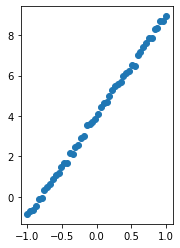

In [6]:
def make_2d_linear_data(slope: float, intercept: float, noise: float, 
                        n_sanples: int, random: int = 2021):
    
    x = np.linspace(-1.0, 1.0, n).reshape(n,1)
    
    np.random.seed(random)
    e = np.random.normal(0.0,noise,n).reshape(n,1)
    
    y = slope*x + intercept + e
    y = y.reshape(n,)

    _ones = np.ones((n,1))

    x.shape

    _ones.shape

    X = np.hstack((_ones, x))
    
    return X,y, e

slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y, e = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

X.shape
y.shape

X[0:3]

print(f"True parameters: {theta_true}")
bayes_error = np.sum(np.matmul(e.T,e))/n  # <== mse
print(f"bayes error: {bayes_error:.2f}")

_ = plt.subplot(121);
_ = plt.scatter(X[:,1],y);

plt.show()

## Batch Gradient descent



Batch gradient descent computes the gradient using the whole dataset. 

In [35]:
def gradient_descent(X: np.array,y: np.array, 
                     cost_func: Callable[[np.array,np.array], np.array], 
                     gradient_func: Callable[[np.array,np.array], np.array], 
                     learning_rate: float, 
                     n_iterations: int, init_guess: np.array) -> dict:
    
    n = X.shape[0] # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    theta_history = np.zeros((n_iterations,d))
    grad_history = np.zeros((n_iterations,d))
    cost_history = np.zeros(n_iterations)
    

    theta = init_guess

    for it in range(0,n_iterations):

        # compute gradients and cost function
        cost_at_theta = cost_func(theta,X,y)
        gradient_at_theta = gradient_func(theta,X,y)

        # log history for ploting
        theta_history[it, :] = theta.T
        grad_history[it,:] = gradient_at_theta.T
        cost_history[it] = cost_at_theta
        
        # update parameters
        dtheta = -learning_rate* gradient_at_theta
        theta = theta + dtheta

    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

### Training 

True parameters: 32.69


(300, 1)

(300,)

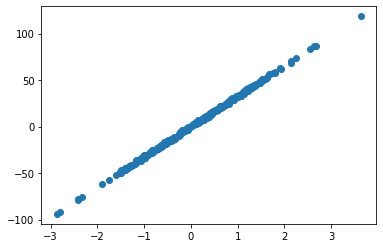

In [36]:
X, y, theta_true = make_regression(n_samples = 300, 
                       n_features=1, 
                       n_informative=1, 
                       noise=1,  # <== This is related with the bayes error. The minimum the cost function can converted
                        coef=True,
                       random_state=2021)

print(f"True parameters: {theta_true:.2f}")

X.shape
y.shape
plt.scatter(X,y)

In [37]:
%%time
lr = 0.05
n_iter = 100

init_guess = np.array([50.0])

theta, history = gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                  lr, n_iter, init_guess)

print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][it]
grad =  history['grad'][it]
cost = history['cost'][it]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true:.2f}")


Initial Guess it: 0 => theta: [50.]; grad: [17.66328858]; cost: 153.96
it: 99 => theta: [32.7167683]; grad: [0.10120038]; cost: 0.45
Expected theta:32.69
CPU times: user 5.94 ms, sys: 2.37 ms, total: 8.31 ms
Wall time: 13.1 ms


### Checking the fit

We can inspect our solution by ploting the prediction against the data.

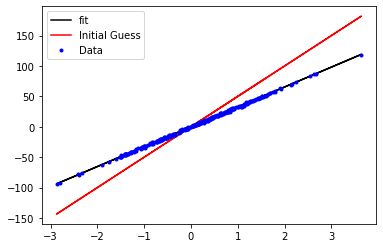

In [13]:
y_pred0 = np.matmul(X,theta0)
y_pred = np.matmul(X,theta)

plt.plot(X,y_pred,c='black', label='fit');
plt.plot(X,y_pred0,'r', label='Initial Guess');
plt.plot(X,y,'b.', label='Data');
plt.legend();

### Cost Function and  learning rate 

Learning rates are central points in the algorithm. Good values of learning rate can make gradient descent find a local minimum quick on the other hand, bad values can lead to problems.

1. large: loss will explode
1. small: takes longer to learn
1. need to find the optmum learning rate

In [14]:
%%time
lr = 2.0
n_iter = 100

theta_big, history_big = gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                          lr, n_iter, init_guess)

lr = 5e-3
n_iter = 100

theta, history_small = gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                        lr, n_iter, init_guess)

CPU times: user 3.12 ms, sys: 5 µs, total: 3.12 ms
Wall time: 3.13 ms


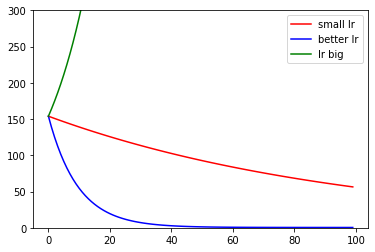

In [15]:
fig,ax = plt.subplots()
_ = ax.plot(range(n_iter),history_small['cost'],'r',label='small lr');
_ = ax.plot(range(n_iter),history['cost'],'b',label='better lr');
_ = ax.plot(range(n_iter), history_big['cost'], 'g', label="lr big");
_ = ax.set_ylim([0, 300.0])
ax.legend();

The learning rate can be tune using a methodology describe in the section **8. TUNNING Learning Rate**

### Changing bayes error


The erro can be decomposed on bias, variance and  bayes error. The bayes erro is inreductivel. There fore the cost should converge to this value.



$y = \hat{y} + \epsilon$

* $\epsilon$ is the bayes error 
* $\epsilon \sim N(h_{\theta}(x),\sigma^2)$  <== Our simulated data and, statistics have this assumption for Multiple Linear regression models. 


True parameters: 32.69


(300, 1)

(300,)

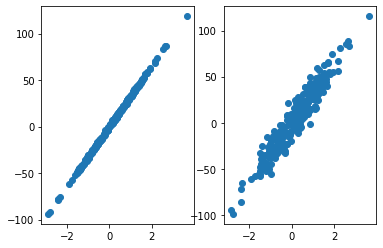

In [18]:
n_sample = 300
std_low_bayes_error = 1

X_low_bayes_error, y_low_bayes_error, theta_true = make_regression(n_samples = n_sample, 
                       n_features=1, 
                       n_informative=1, 
                       noise=std_low_bayes_error,  # <== Low bayes error
                        coef=True,
                       random_state=2021)

print(f"True parameters: {theta_true:.2f}")


std_high_bayes_error = 10
X_high_bayes_error, y_high_bayes_error, theta_true = make_regression(n_samples = n_sample, 
                       n_features=1, 
                       n_informative=1, 
                       noise=std_high_bayes_error,  # <== High bayes error
                        coef=True,
                       random_state=2021)

X_low_bayes_error.shape
y_low_bayes_error.shape

_ = plt.subplot(121);
_ = plt.scatter(X_low_bayes_error,y_low_bayes_error);
_ = plt.subplot(122);
_ = plt.scatter(X_high_bayes_error,y_high_bayes_error);

plt.show()

In [19]:
%%time
lr = 0.05
n_iter = 100

init_guess = np.array([50.0])

theta, history_low_bayes_error = gradient_descent(X_low_bayes_error, y_low_bayes_error, cost_func_linear_regression, gradient_linear_regression, 
                                  lr, n_iter, init_guess)


theta, history_high_bayes_error = gradient_descent(X_high_bayes_error, y_high_bayes_error, cost_func_linear_regression, gradient_linear_regression, 
                                  lr, n_iter, init_guess)


CPU times: user 5.81 ms, sys: 2.35 ms, total: 8.16 ms
Wall time: 5.95 ms


In [20]:
J_low_bayes_error = 1.0/2.0*pow(std_low_bayes_error,2)
std_low_bayes_error
J_low_bayes_error  # <= half of std^2

history_low_bayes_error['cost'][-1]

print()
J_high_bayes_error = 1.0/2.0*pow(std_high_bayes_error,2)
std_high_bayes_error
J_high_bayes_error # <= half of std^2

history_high_bayes_error['cost'][-1]

1

0.5

0.4498957115700963

10

50.0

44.491052934509085

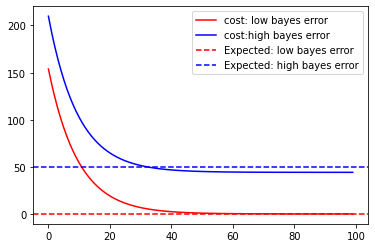

In [21]:
fig,ax = plt.subplots()
_ = ax.plot(range(n_iter),history_low_bayes_error['cost'],'r',label='cost: low bayes error');
_ = ax.plot(range(n_iter),history_high_bayes_error['cost'],'b',label='cost:high bayes error');
_ = ax.axhline(y=J_low_bayes_error, color='r', linestyle='--',label='Expected: low bayes error');
_ = ax.axhline(y=J_high_bayes_error, color='b', linestyle='--',label='Expected: high bayes error');
ax.legend();

### Case: 2D feature space 

In [26]:
slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

In [27]:
%%time
lr =0.1
n_iter = 200

init_guess = np.array([-10.0, -10.0])

theta, history = gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr, n_iter, init_guess)

print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][it]
grad =  history['grad'][it]
cost = history['cost'][it]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true}")


Initial Guess it: 0 => theta: [-10. -10.]; grad: [-14.01099638  -5.19944385]; cost: 137.12
it: 199 => theta: [4.01099637 4.97332617]; grad: [-1.09831868e-08 -4.61640576e-03]; cost: 0.00
Expected theta:[4. 5.]
CPU times: user 8.77 ms, sys: 4.73 ms, total: 13.5 ms
Wall time: 11.7 ms


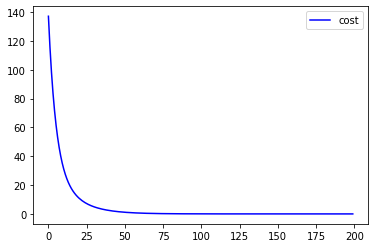

In [28]:
fig,ax = plt.subplots()
_ = ax.plot(range(n_iter),history['cost'],'b',label='cost');
ax.legend();

Generating parameters space

In [29]:
grid_size = 300
theta1 = np.linspace(-10, 10, grid_size)
theta2 = np.linspace(-10, 10, grid_size)

Theta1,Theta2 = np.meshgrid(theta1,theta2)

J_grid = np.zeros((grid_size,grid_size))
theta = np.array([0.0,0.0]).T
for r in range(0,grid_size):
    
    for c in range(0,grid_size):
        
        theta[0] = theta1[r]
        theta[1] = theta2[c]
        
        J_grid[r,c] = cost_func_linear_regression(theta, X,y)

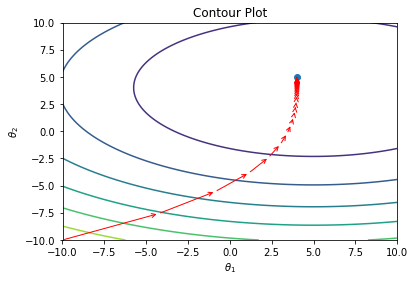

In [30]:
cp = plt.contour(Theta1, Theta2, J_grid)

thetas = [ history['theta'][k] for k in range(0, len(history['cost']),5) ] 
for j in range(1,len(thetas)):
    _ = plt.annotate('', xy=thetas[j], xytext=thetas[j-1],
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center');

plt.title('Contour Plot')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.scatter(theta_true[0],theta_true[1])  # <= Expected true value
plt.show();

## Stochastic Gradient Descent

In stochastic Gradient descent, instead of use the entire data $X$ to compute the gradients, we randonly peak one sample and use it to have an estimation of the gradients at that point. The estimation will not be accurate, but in average the algorithm will converge to an optimal solution. The algorithm is ilustrade bellow:

The update formula is given by:


$
\theta = \theta - \eta \nabla_{\theta}J(X_i)
$


* Start with initi guess: $\theta$

* for each iteration

    1. random shuffle $X$
    1. for i=0,1,..., n-1
        1. Compute  $\nabla_{\theta}J(X_i)$
        1. update the parameters $\theta = \theta - \eta \nabla_{\theta}J(X_i)$


In [38]:
def stochastic_gradient_descent(X: np.array,y: np.array, 
                     cost_func: Callable[[np.array,np.array], np.array], 
                     gradient_func: Callable[[np.array,np.array], np.array], 
                     learning_rate: float, 
                     n_iterations: int, init_guess: np.array) -> dict:
    
    n = X.shape[0]  # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    Xy = np.hstack((X,y.reshape((n,1))))
    
    theta_history = []
    grad_history = []
    cost_history = []
     
    theta = init_guess
    for it in range(1,n_iterations):

        cost = 0.0
        
        # shuffle data
        rand_idx = np.random.randint(0, n, n )
        data_shuffle = Xy[rand_idx,:]
        
        for i in range(n):

            X_i = data_shuffle[i,:-1].reshape(1, d)
            y_i = data_shuffle[i,-1]
            
            cost += cost_func(theta,X_i,y_i)
            gradient_at_theta = gradient_func(theta,X_i,y_i)  # gradient approximation using 1 data point
            
            # log history for oploting
            theta_history.append(theta.T)
            grad_history.append(gradient_at_theta)
            
           # update parameters
            dtheta = -learning_rate* gradient_at_theta

            theta = theta + dtheta
                
        cost_history.append(cost/n)   # <= average loss in the epoch 
        
    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

#### Case: 1D parameter sapce

True parameters: 26.52


(50, 1)

(50,)

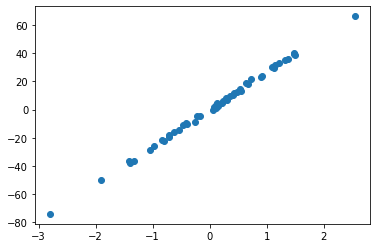

In [39]:
# Simulating data
X, y, theta_true = make_regression(n_samples = 50, 
                       n_features=1, 
                       n_informative=1, 
                       noise=1.0,
                       coef=True,
                       random_state=2021)

print(f"True parameters: {theta_true:.2f}")

X.shape
y.shape
plt.scatter(X,y)

In [40]:
%%time
lr =0.001
n_iter = 120

init_guess = np.array([20])

theta, history = stochastic_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr, n_iter, init_guess)

print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true:.2f}")


Initial Guess it: 0 => theta: [20]; grad: [-0.18600079]; cost: 16.57
it: 119 => theta: [26.50866704]; grad: [0.80460918]; cost: 0.54
Expected theta:26.52
CPU times: user 165 ms, sys: 6.18 ms, total: 171 ms
Wall time: 171 ms


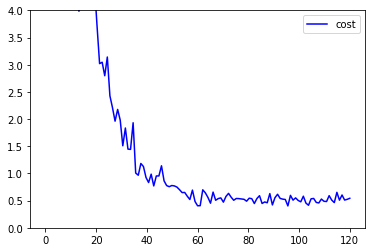

In [44]:
fig,ax = plt.subplots()

cost = history['cost']
    
m = len(cost)
x = np.linspace(0,n_iter,m)

_ = ax.plot(x,cost,'b',label='cost');
_ = ax.set_ylim([0, 4.0])
ax.legend();

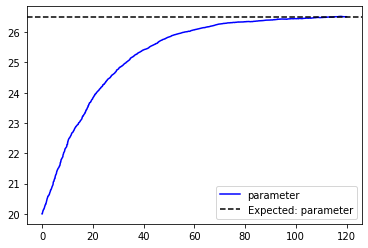

In [45]:
fig,ax = plt.subplots()

parameters = history['theta']
    
m = len(parameters)
x = np.linspace(0,n_iter,m)
    
_ = ax.plot(x,parameters,'b',label='parameter');
_ = ax.axhline(y=theta_true, color='k', linestyle='--',label='Expected: parameter');
ax.legend();

#### Case: 2D parameters space

In [46]:
slope = 5.0 
intercept = 4.0
noise = 0.5
n = 50

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

In [47]:
%%time
lr = 0.01
n_iter = 30

init_guess = np.array([-10.0, -10.0])

theta, history = stochastic_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr, n_iter, init_guess)

print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true}")


Initial Guess it: 0 => theta: [-10. -10.]; grad: [-0.43347429  0.3803958 ]; cost: 109.68
it: 29 => theta: [4.05686163 4.88635486]; grad: [-0.57379776  0.57379776]; cost: 0.12
Expected theta:[4. 5.]
CPU times: user 46.7 ms, sys: 1.79 ms, total: 48.5 ms
Wall time: 48.5 ms


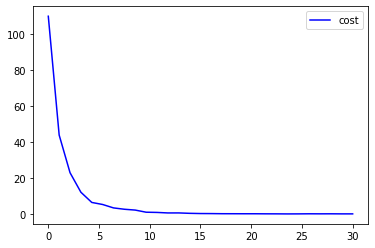

In [48]:
fig,ax = plt.subplots()

cost = history['cost']
    
m = len(cost)
x = np.linspace(0,n_iter,m)
    
_ = ax.plot(x,cost,'b',label='cost');
ax.legend();

Generating parameters space

In [49]:
grid_size = n_iter
theta1 = np.linspace(-10, 10, grid_size)
theta2 = np.linspace(-10, 10, grid_size)

Theta1,Theta2 = np.meshgrid(theta1,theta2)

J_grid = np.zeros((grid_size,grid_size))
theta = np.array([0.0,0.0]).T
for r in range(0,grid_size):
    
    for c in range(0,grid_size):
        
        theta[0] = theta1[r]
        theta[1] = theta2[c]
        
        J_grid[r,c] = cost_func_linear_regression(theta, X,y)

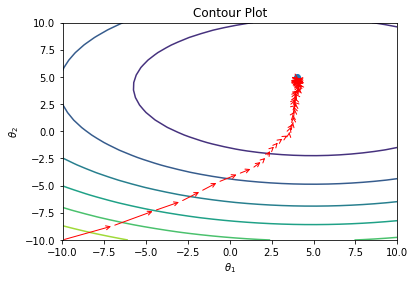

In [51]:
cp = plt.contour(Theta1, Theta2, J_grid)

thetas = [ history['theta'][k] for k in range(0, len(history['theta']),20) ] 
for j in range(1,len(thetas)):
    _ = plt.annotate('', xy=thetas[j], xytext=thetas[j-1],
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center');

plt.title('Contour Plot')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.scatter(theta_true[0],theta_true[1])  # <= Expected true value
plt.show();

## Mini Batch Gradient Descent


res:
* mini batch update formula: https://stats.stackexchange.com/questions/140811/how-large-should-the-batch-size-be-for-stochastic-gradient-descent

* desambiguation: https://stats.stackexchange.com/questions/167088/stochastic-gradient-descent-vs-online-gradient-descent

In the case of mini-batch, instead of making an update with gradients of one data point at a time, we calculate gradients of a batch of data points of size B. 


$
\theta = \theta - \eta(t) \frac{1}{B} \sum_{b=0}^{B - 1}  \nabla J_{\theta}(\theta, m_b)
$

where $B$ is the cardinality of $m_b$ (the size of the batch).

1. Batch gradient descent, $𝐵=|X|$
1. Online stochastic gradient descent: $𝐵=1$
1. Mini-batch stochastic gradient descent: $𝐵>1$ but $𝐵<|𝑥|$.

> Note: in real life we're reading these training example data from memory and, due to cache pre-fetching and other memory tricks done by your computer, your algorithm will run faster if the memory accesses are coalesced, i.e. when you read the memory in order and don't jump around randomly. So, most SGD implementations shuffle the dataset and then load the examples into memory in the order that they'll be read.

> NOte: Online stochastic gradient descent is not the same as Sthocastibc gradient descent. The forst use the most recently gradients to update the parameters while the latter usepic up a random point. 

The function $\eta(t)$ is called learning rate schedule and it is constant in this notebook. 


> NOte: proper weight should be assigned to each mini-batch as a function of its size, when there are mini-batches with different size because number of training examples are not exatly divide by batch size.

In [53]:
def create_mini_batches(data_shuffle, batch_size):
    
    n = data_shuffle.shape[0]
    mini_batches = []
    
    for k in np.arange(0, n, batch_size):
        
        X_mini = data_shuffle[k:k+batch_size,:-1]
        y_mini = data_shuffle[k:k+batch_size,-1]
        
        mini_batches.append((X_mini,y_mini))
    return mini_batches

def mini_batch_gradient_descent(X: np.array,y: np.array, 
                     cost_func: Callable[[np.array,np.array], np.array], 
                     gradient_func: Callable[[np.array,np.array], np.array], 
                     learning_rate: float, 
                     n_iterations: int, 
                     batch_size: int,
                     init_guess: np.array) -> dict:
    
    n = X.shape[0] # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    theta = init_guess

    Xy = np.hstack((X,y.reshape((n,1))))
        
    theta_history = []
    grad_history = []
    cost_history = []
 
    for it in range(1,n_iterations):
        
        data_shuffle = Xy.copy()
        np.random.shuffle(data_shuffle)
        
        cost = 0.0
        mini_batches = create_mini_batches(data_shuffle,batch_size)
        
        for X_mini, y_mini in mini_batches:

            # compute the gradients and cost function
            cost += cost_func(theta,X_mini,y_mini)
            gradient_at_theta = gradient_func(theta,X_mini,y_mini)  # gradient approximation
        
            # log history for oploting
            theta_history.append(theta.T)
            grad_history.append(gradient_at_theta)
            
           # update parameters
            dtheta = -learning_rate* gradient_at_theta

            theta = theta + dtheta
            
        cost_history.append(cost/len(mini_batches)) # << average loss in the epoch 

    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

### Case: 2D feature space compare all approaches (Linear Regression)

In [54]:
slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

In [55]:
%%time
n_iter = 150

print(f"#samples: {n}")

init_guess = np.array([-10.0, -10.0])
d1 = np.array

history = dict()

batch_sizes = [('sthocastic',1, 0.02,  np.array([-10.0, -10.0]) ),
               ('mini',12, 0.02,  np.array([-9.0, -10.0])), 
               ('vanila',n, 0.02, np.array([-10.0, -9.0]) )]

for name, bs, lr, init_guess in batch_sizes:

    theta, history[name] = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr, n_iter,bs, init_guess)

    print(f"{name}, bs: {bs}")
    theta0 = history[name]['theta'][0]
    grad0 =  history[name]['grad'][0]
    cost0 = history[name]['cost'][0]

    print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

    it = n_iter -1
    theta = history[name]['theta'][-1]
    grad =  history[name]['grad'][-1]
    cost = history[name]['cost'][-1]

    print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
    print(f"Expected theta:{theta_true}")
    print()

#samples: 50
sthocastic, bs: 1
Initial Guess it: 0 => theta: [-10. -10.]; grad: [-16.09563875  -2.29937696]; cost: 71.11
it: 149 => theta: [4.00485465 4.9856539 ]; grad: [-0.02859749 -0.01108882]; cost: 0.00
Expected theta:[4. 5.]

mini, bs: 12
Initial Guess it: 0 => theta: [ -9. -10.]; grad: [-10.63049228  -3.36001783]; cost: 130.95
it: 149 => theta: [4.00719305 4.89946225]; grad: [-0.0648019  -0.00561593]; cost: 0.01
Expected theta:[4. 5.]

vanila, bs: 50
Initial Guess it: 0 => theta: [-10.  -9.]; grad: [-14.01099638  -4.85250508]; cost: 132.09
it: 149 => theta: [ 3.30641977 -0.00410597]; grad: [-0.70457661 -1.73148062]; cost: 4.57
Expected theta:[4. 5.]

CPU times: user 251 ms, sys: 12.1 ms, total: 263 ms
Wall time: 331 ms


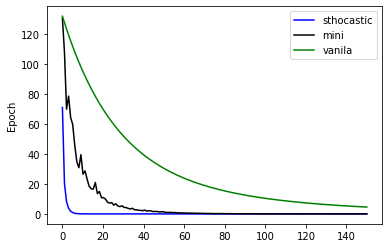

In [57]:
colors = ['b','k','g']

fig,ax = plt.subplots()
for idx, hyper_params in enumerate(batch_sizes):
    
    name, bs, lr,_ = hyper_params
    
    cost = history[name]['cost']
    
    m = len(cost)
    x = np.linspace(0,n_iter,m)
    
    _ = ax.plot(x,cost,colors[idx],label=name);

_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();

* **Confirming fit**

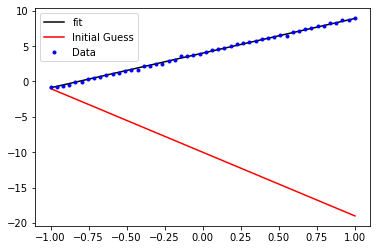

In [58]:
name = 'mini'

theta = history[name]['theta'][-1]
y_pred0 = np.matmul(X,init_guess)
y_pred = np.matmul(X,theta)

y_pred.shape

plt.plot(X[:,1],y_pred,c='black', label='fit');
plt.plot(X[:,1],y_pred0,'r', label='Initial Guess');
plt.plot(X[:,1],y,'b.', label='Data');
plt.legend();

In [59]:
# Generatin 2d feature space
grid_size = 500

theta1 = np.linspace(-10.0, 10.0, grid_size)
theta2 = np.linspace(-10.0, 10.0, grid_size)

Theta1,Theta2 = np.meshgrid(theta1,theta2)

J_grid = np.zeros((grid_size,grid_size))
theta = np.array([0.0,0.0]).T

for r in range(0,grid_size):
    
    for c in range(0,grid_size):
        
        theta[0] = theta1[r]
        theta[1] = theta2[c]
        
        #J_grid[r,c] = parabola(theta)
        J_grid[r,c] = cost_func_linear_regression(theta, X,y)

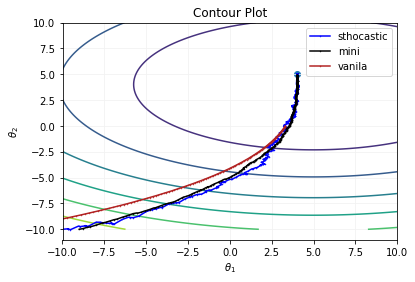

In [60]:
cp = plt.contour(Theta1, Theta2, J_grid)
colors = ['b','k','firebrick']

for idx, hyper_params in enumerate(batch_sizes):
    name, bs, lr,init_guess = hyper_params
    
    theta_x = [ history[name]['theta'][k][0] for k in range(0, len(history[name]['theta']),1) ]
    theta_y = [ history[name]['theta'][k][1] for k in range(0, len(history[name]['theta']),1) ]
    
    plt.plot(theta_x, theta_y, color=colors[idx], marker='.', markersize=1, label=name)

plt.title('Contour Plot')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.scatter(intercept,slope)  # <= Expected true value
plt.grid(axis='x', color='0.95')
plt.grid(axis='y', color='0.95')
plt.legend()
plt.show();

## TUNING Learning rate 

https://miguel-data-sc.github.io/2017-11-05-first/
https://arxiv.org/abs/1506.01186

1. learning rate finding 
1. learnig rate find vs batchs size

Needs to introduce learning rate shdedule $\eta = \eta(t)$ in mini batch algo

In [69]:
from abc import ABC, abstractmethod

class LearningRateScheduler(ABC):

    def __init__(self, lr0: float ):
        
        self._lr0 = lr0
        
    @abstractmethod
    def run(it: int) -> float: 
        return
    
class ConstLearningRateScheduler(LearningRateScheduler):
    
    def run(self, it: int) -> float: 
        return self._lr0
    
class FindLearningRateScheduler(LearningRateScheduler):
    
    def __init__(self, lr0: float, number_of_lr_per_order: int = 4 ):
    
        super().__init__(lr0)
        
        self._lr0 = lr0
        self._number_of_lr_per_order = number_of_lr_per_order
    
    def run(self, it: int) -> float: 
        
        lr = self._lr0*(10**(it/self._number_of_lr_per_order))
        
        return lr

In [70]:
n_iter = 55

lr_scheduler = FindLearningRateScheduler(1e-5,number_of_lr_per_order=10)

lrs = np.zeros((n_iter,))
for it in range(n_iter):
    
    lrs[it] = lr_scheduler.run(it)
    

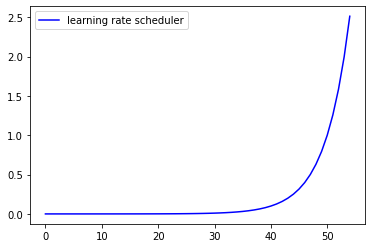

In [71]:
fig,ax = plt.subplots()
_ = ax.plot(range(n_iter),lrs,'b',label='learning rate scheduler');
ax.legend();

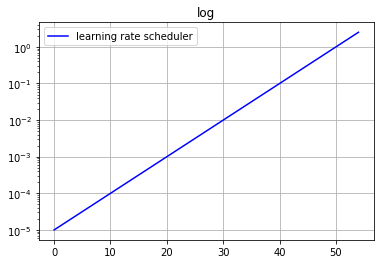

In [72]:
plt.subplots()
plt.plot(range(n_iter),lrs,'b',label='learning rate scheduler');
plt.yscale('log');
plt.legend();
plt.title('log');
plt.grid(True);

In [73]:
def create_mini_batches(data_shuffle, batch_size):
    
    n = data_shuffle.shape[0]
    mini_batches = []
    
    for k in np.arange(0, n, batch_size):
        
        X_mini = data_shuffle[k:k+batch_size,:-1]
        y_mini = data_shuffle[k:k+batch_size,-1]
        
        mini_batches.append((X_mini,y_mini))
    return mini_batches

def mini_batch_gradient_descent(X,y, cost_func, gradient_func, 
                                learning_rate_scheduler: Callable[[float,int], float],
                                n_iterations: int,
                                batch_size: int, 
                                init_guess: np.array,seed: int =1):
    
    n = X.shape[0] # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    # init guess
    if init_guess is None:
        theta = np.random.randn(d)
        
    else:
        theta = init_guess


    Xy = np.hstack((X,y.reshape((n,1))))
        
    theta_history = []
    grad_history = []
    cost_history = []
 
    #print(f"theta0: {theta}")
    for it in range(0,n_iterations):
        
        #rand_idx = np.random.randint(0, n, n )
        #data_shuffle = Xy[rand_idx,:]
        
        data_shuffle = Xy.copy()
        np.random.shuffle(data_shuffle)
        
        cost = 0.0
        mini_batches = create_mini_batches(data_shuffle,batch_size)
        
        for X_mini, y_mini in mini_batches:

            # compute the gradients and cost function
            
            #cost_at_theta = cost_func(theta,X_mini,y_mini)
            cost += cost_func(theta,X_mini,y_mini)
            gradient_at_theta = gradient_func(theta,X_mini,y_mini)  # gradient approximation using 1 data point
            

            # log history for oploting
            theta_history.append(theta.T)
            grad_history.append(gradient_at_theta)
            
           # update parameters
            learning_rate = learning_rate_scheduler.run(it)
            dtheta = -learning_rate* gradient_at_theta

            theta = theta + dtheta
            
        cost_history.append(cost/len(mini_batches)) # << average loss in the epoch 

    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

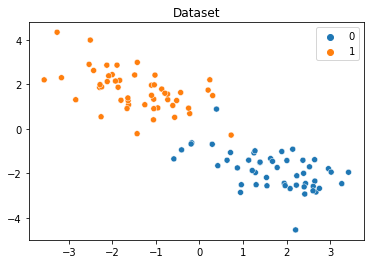

In [74]:
# other options are also available
X, y = make_classification(
    n_samples=100, 
    n_classes=2,
    n_clusters_per_class=1,
    n_features=2,
    n_redundant = 0,
    n_informative = 2,
    n_repeated = 0,
    weights=[0.5,0.5], # balanced classes
    flip_y=0.001, # add noisy the default value for flip_y is 0.1%
    class_sep=1.7, # class_sep is 1.0. The lower the value, the harder classification is.
    random_state=2020) 

ax = sns.scatterplot(X[:,0],X[:,1],hue=y);
ax.set_title("Dataset");

In [75]:
lr = 0.1
n_iter = 200
bs = 100

lr_scheduler = ConstLearningRateScheduler(lr)

init_guess = np.array([1.0,0.5])

theta, history = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)


theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true}")
print()

Initial Guess it: 0 => theta: [1.  0.5]; grad: [ 2.46180965 -2.11780916]; cost: 1.10
it: 199 => theta: [-0.02352229  0.19788771]; grad: [7.42818314e-05 6.78048566e-05]; cost: 0.16
Expected theta:[4. 5.]



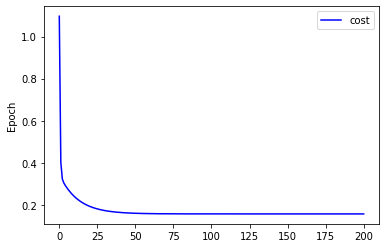

In [76]:
cost = history['cost']
    
    
m = len(cost)
x = np.linspace(0,n_iter,m)
    
fig,ax = plt.subplots()
_ = ax.plot(x,cost,'b',label='cost');
_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();

In [77]:
n_iter = 54
bs = 100

lr_scheduler = FindLearningRateScheduler(1e-5,number_of_lr_per_order=10)

init_guess = np.array([1.0,0.5])

theta, history = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)


theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true}")
print()

Initial Guess it: 0 => theta: [1.  0.5]; grad: [ 2.46180965 -2.11780916]; cost: 1.10
it: 53 => theta: [-0.45956011  0.70088545]; grad: [-3.09255999  3.3984169 ]; cost: 1.69
Expected theta:[4. 5.]



first 5 lrs: [1.00000000e-05 1.25892541e-05 1.58489319e-05 1.99526231e-05
 2.51188643e-05]
last 5 lrs: [0.79432823 1.         1.25892541 1.58489319 1.99526231]
last 5 cost: [0.16923198299949826, 0.16242434361657435, 0.1589434993911103, 0.1726004425914452, 1.685589737833711]


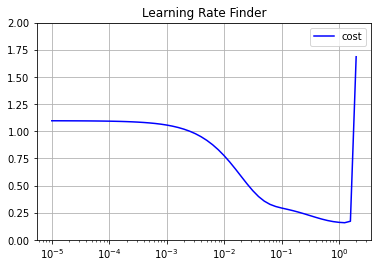

In [78]:
lrs = np.zeros((n_iter,))
for it in range(n_iter):
    
    lrs[it] = lr_scheduler.run(it)


cost = history['cost'] 
print(f"first 5 lrs: {lrs[0:5]}")
print(f"last 5 lrs: {lrs[-5:]}")
print(f"last 5 cost: {cost[-5:]}")


plt.subplots()
plt.plot(lrs,cost,'b',label='cost');
plt.xscale('log');
plt.ylim(0.0,2.0);
plt.legend();
plt.title('Learning Rate Finder');
plt.grid(True);

In [79]:
sim = [('manual', 0.01),
       ('tuned lr',0.2 )]

n_iter = 300
init_guess
bs

for name, lr in sim:

    lr_scheduler = ConstLearningRateScheduler(lr)
    
    theta, history[name] = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)


    print(f"{name}, lr: {lr}")
    theta0 = history[name]['theta'][0]
    grad0 =  history[name]['grad'][0]
    cost0 = history[name]['cost'][0]

    print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

    it = n_iter -1
    theta = history[name]['theta'][-1]
    grad =  history[name]['grad'][-1]
    cost = history[name]['cost'][-1]

    print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
    
    z = np.matmul(X,theta)  # nx1
    h = 1.0/(1.0 + np.exp(-z))
    y_pred = h > 0.5

    acc = accuracy_score(y, y_pred)
    print(f"accuracy: {acc}")
    
    #print(f"Expected theta:{theta_true}")
    print()


array([1. , 0.5])

100

manual, lr: 0.01
Initial Guess it: 0 => theta: [1.  0.5]; grad: [ 2.46180965 -2.11780916]; cost: 1.10
it: 299 => theta: [0.18585499 0.38900841]; grad: [0.08524474 0.07781186]; cost: 0.17
accuracy: 0.94

tuned lr, lr: 0.2
Initial Guess it: 0 => theta: [1.  0.5]; grad: [ 2.46180965 -2.11780916]; cost: 1.10
it: 299 => theta: [-0.0237049   0.19772102]; grad: [2.76054291e-12 2.51982213e-12]; cost: 0.16
accuracy: 0.97



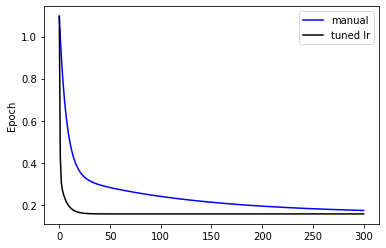

In [80]:
colors = ['b','k','g']

fig,ax = plt.subplots()
for idx, hyper_params in enumerate(sim):
    
    name, lr = hyper_params= hyper_params
    
    cost = history[name]['cost']
    
    m = len(cost)
    x = np.linspace(0,n_iter,m)
    
    _ = ax.plot(x,cost,colors[idx],label=name);
    
#_ = ax.set_ylim([6, 8])
_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();

## Gradient Exploding

In this section we are going to show that in the presence of outliers, gradient descent can become unstable and the gradients can increase and explode to numerical precision of the computer. The stochastic gradients descent is the most sensible to oultiers because the computation of the gradient depends only the one sample.


(50, 2)

(51, 2)

(50,)

(51,)

True parameters: [4. 5.]


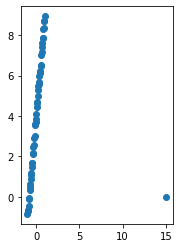

In [85]:
slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

outlier_X = [1., 15]
outlier_y = 0.0

X1 = np.vstack((X,outlier_X))
y1 = np.hstack((y,outlier_y))

X.shape
X1.shape

y.shape
y1.shape

print(f"True parameters: {theta_true}")

_ = plt.subplot(121);
_ = plt.scatter(X1[:,1],y1);

plt.show()

In [86]:
lr = 0.01
n_iter = 30
bs = 51
init_guess = np.array([-10.0, -10.0])

sim = [('No outlier: sthochastic',1,(X,y)),
       ('Outlier: sthochastic',1, (X1,y1)),
       ('Outlier: mini',8, (X1,y1)),
       ('Outlier: vanila',51, (X1,y1))
      ]

history = {}
for name, bs, data in sim:
    
    X_sim,y_sim = data
    
    theta, history[name] = mini_batch_gradient_descent(X_sim, y_sim, cost_func_linear_regression, gradient_linear_regression, 
                                             lr, n_iter,bs, init_guess)
    print()
    theta0 = history[name]['theta'][0]
    grad0 =  history[name]['grad'][0]
    cost0 = history[name]['cost'][0]

    print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

    it = n_iter -1
    theta = history[name]['theta'][-1]
    grad =  history[name]['grad'][-1]
    cost = history[name]['cost'][-1]

    print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
    print(f"Expected theta:{theta_true}")

AttributeError: 'float' object has no attribute 'run'

KeyError: 'No outlier: sthochastic'

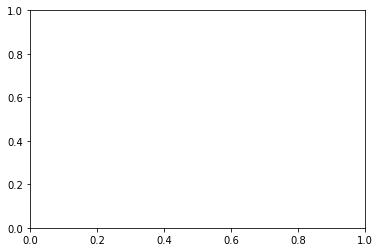

In [87]:
colors = ['b','k','g','r']

fig,ax = plt.subplots()
for idx, sim_param in enumerate(sim):
    
    name, bs, data = sim_param
    
    cost = history[name]['cost']
    
    m = len(cost)
    x = np.linspace(0,n_iter,m)
    
    _ = ax.plot(x,cost,colors[idx],label=name);

_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();


## Gradient vanish

1. bad initialzation (**logistic regression**)
1. deeper neural network (See intro_back_propagation) DO small discussion

In [88]:
# other options are also available
X, y = make_classification(
    n_samples=10, 
    n_classes=2,
    n_clusters_per_class=1,
    n_features=2,
    n_redundant = 0,
    n_informative = 2,
    n_repeated = 0,
    weights=[0.5,0.5], # balanced classes
    flip_y=0.001, # add noisy the default value for flip_y is 0.1%
    class_sep=1.7, # class_sep is 1.0. The lower the value, the harder classification is.
    random_state=2020) 
X.shape
X[0:3]

X.max(axis=0)
X.min(axis=0)

y.shape
y[0:3]


(10, 2)

array([[-2.15267014,  1.64632745],
       [-1.77172127,  1.52979319],
       [ 1.6864323 , -1.74495532]])

array([2.46018457, 1.64632745])

array([-2.15267014, -2.45159076])

(10,)

array([1, 1, 0])

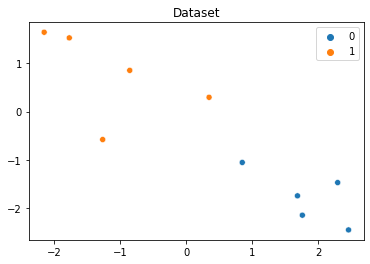

In [89]:

ax = sns.scatterplot(X[:,0],X[:,1],hue=y);
ax.set_title("Dataset");

In [90]:
lr = 0.05
n_iter = 150
bs = 1

init_guess = np.array([1.0, 0.5])

z = np.matmul(X,init_guess)  # nx1
h = 1.0/(1.0 + np.exp(-z))

z.shape
z[0:3]

h.shape
h[0:3]

cost_func_logistic_regression(init_guess,X,y)
gradient_logistic_regression(init_guess,X,y)

(10,)

array([-1.32950641, -1.00682467,  0.81395464])

(10,)

array([0.20924102, 0.26760173, 0.69295157])

1.2418866104904696

array([11.06728263, -8.9374648 ])

In [91]:


theta, history = mini_batch_gradient_descent(X, y, cost_func_logistic_regression, gradient_logistic_regression, 
                                             lr, n_iter,bs, init_guess)

print("agora vai")
print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost}")


AttributeError: 'float' object has no attribute 'run'

In [571]:
theta0
grad0
cost0

theta

array([1. , 0.5])

array([ 1.89723487, -1.21497497])

0.9129825738872123

array([-2.24729153,  2.22143852])

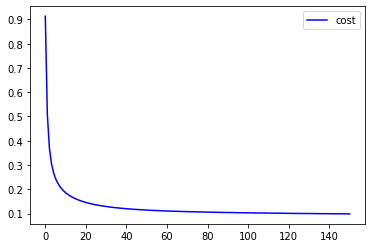

In [572]:
fig,ax = plt.subplots()

cost = history['cost']
    
m = len(cost)
x = np.linspace(0,n_iter,m)
    
_ = ax.plot(x,cost,'b',label='cost');

ax.legend();

In [517]:
z = np.matmul(X,theta)  # nx1
h = 1.0/(1.0 + np.exp(-z))
y_pred = h > 0.5

accuracy_score(y, y_pred)

0.98

* **Start from small grads as possible**

1. find init_guess closest to a solution. We know the grads is close to zro there 
1. train a model starting for this position ans show that it i snot learning
1. The problems rises when we have multi-layer DNN. Neuron can die in a local minimum and cannot learn anymore


In [566]:
init_guess = np.array([10.0, 10.5])


d = 2
n = 100

xx = np.linspace(0.0,5000000.0,n)

norm_x = np.zeros((n,1))
grad_norm = np.zeros((n,1))
z = np.zeros((n,1))
h = z

for idx, x in enumerate(xx):
    
    init_guess = np.array([-x, x])
    norm_x[idx] = np.sqrt(np.matmul(init_guess.T,init_guess))
    
    grad = gradient_logistic_regression(init_guess,X,y)
    
    grad_norm[idx] = np.sqrt(np.matmul(grad.T,grad))
    
    
    z = np.matmul(X,init_guess)  # nx1
    h[idx] = 1.0/(1.0 + np.exp(-z))
 
    cost[idx] = cost_func_logistic_regression(init_guess,X,y)


ValueError: could not broadcast input array from shape (100) into shape (1)

In [561]:
xx[-5:-1]
grad_norm[-5:-1]

array([4797979.7979798 , 4848484.84848485, 4898989.8989899 ,
       4949494.94949495])

array([[1.21390831],
       [1.21390831],
       [1.21390831],
       [1.21390831]])

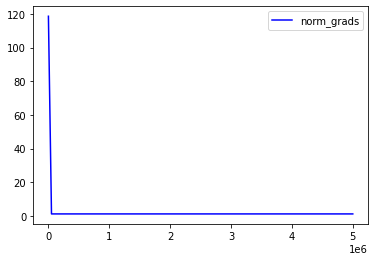

In [560]:
    
fig,ax = plt.subplots()

_ = ax.plot(xx,grad_norm,'b',label='norm_grads');

ax.legend();

In [576]:
init_guess = np.array([-2.86518817,3.3551])

theta, history = mini_batch_gradient_descent(X, y, cost_func_logistic_regression, gradient_logistic_regression, 
                                             lr, n_iter,bs, init_guess)

print("agora vai")
print()
theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost}")

agora vai

Initial Guess it: 0 => theta: [-2.86518817  3.3551    ]; grad: [ 1.80079434e-05 -1.37721850e-05]; cost: 0.08707387109777445
it: 149 => theta: [-3.08587957  3.81855903]; grad: [0.19572736 0.08938462]; cost: 0.08354973676336896


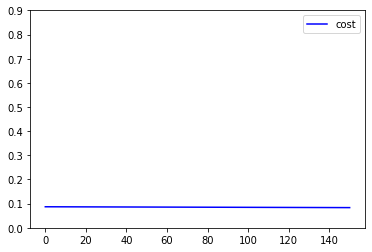

In [579]:
fig,ax = plt.subplots()

cost = history['cost']
    
m = len(cost)
x = np.linspace(0,n_iter,m)
    
_ = ax.plot(x,cost,'b',label='cost');
ax.set_ylim(0.0,0.9)
ax.legend();

## Momentum 

* Gradient Descent with momentum

    * The problem mmentum address is to speedup the steps in the regions where gradients is too small (Vanish). It helps the gradient:
        * escape from local small valleys 
        * speedup in plateuas and
        * also avoid stopping in saddle points
    * Intuition: adds term that can be understood as innertial term in the update 
    * Gradients tends to jiggle more when it is closed to minimum because the gradients are change directions. Othe siolutions try to address this peoblems: **AdaGrad**, **RMSProp** and **Adam (momentum+ RMSProp) (This is the best available right now)**

$
d\theta = \beta d\theta + \eta (1 - \beta)  \nabla_{\theta} J(\theta) 
$
    
Default value $\beta = 0.9$ works well in many situations
* $\beta = 0$: we have normall gardeints (no momentum)
* $\beta = 1$: oure momentum and the slopes (gradients) are ignored in the update


----------

The problem this extension tries to tackle is slow convergence in the standard gradient descent. When the slope becomes too gentle gradient descent takes too small steps, has hardship escaping valleys and even may stop at a saddle point. In addition, the slope may be oscillating around the general direction of the slope following ravines in the loss function.

The momentum was inspired in the concpet of exponential moving average (exponential smoothing).


$
V_t = \beta V_{t-1} + (1-\beta)S_t
$


where $S_t$ is a new observation and $\beta = [0,1]$. The new smoooth value is linear combination of the new observation $S_t$ and the old smooothed value $V_{t-1}$ and $\beta$ determine the fraction of the old smooothed value will be "remember". Analogy of pyhsical system, $V$ denotes velocity and the term $\beta V_{t-1}$ is the resistence applied in the previous velocity and $(1 -\beta)S_t$ is the acceleration at current time. 


This equation is to reduce rhe gradients oscilations because a considered amount of the gradient oscilation is cancelled due to the resistence term. The equation for gradient is given b



$
V_t = \beta V_{t-1} + (1-\beta) \eta \nabla J(\theta)
$

Since the learning rate can be selected to account for $(1- \beta)$ term thus making it redundant, this term is usually omitted in the literature.


$
V_t = \beta V_{t-1} + \eta \nabla J(\theta)
$


Where $\eta = (1-\beta) \eta $. The parameters are updated with the formula:


$
\theta_t = \theta_{t-1} + V_t
$

Changing mini batches to include moemntum

In [92]:
def gradient_descent(X,y, cost_func, gradient_func, learning_rate: float, beta: float,
                     n_iterations: int, init_guess: np.array):
    
    n = X.shape[0] # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    theta_history = np.zeros((n_iterations,d))
    grad_history = np.zeros((n_iterations,d))
    cost_history = np.zeros(n_iterations)
    
    # init guess
    if init_guess is None:
        theta = np.random.randn(d)
        
    else:
        theta = init_guess

    V = 0.0
    #print(f"theta0: {theta}")
    for it in range(0,n_iterations):

        # compute gradients and cost function
        cost_at_theta = cost_func(theta,X,y)
        gradient_at_theta = gradient_func(theta,X,y)

        # log history for ploting
        theta_history[it, :] = theta.T
        grad_history[it,:] = gradient_at_theta.T
        cost_history[it] = cost_at_theta
        
        # update parameters
        #V = beta*V - learning_rate*(1.0-beta)*gradient_at_theta
        V = beta*V - learning_rate*gradient_at_theta
        theta = theta + V

    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

In [93]:
# other options are also available
X, y = make_classification(
    n_samples=100, 
    n_classes=2,
    n_clusters_per_class=1,
    n_features=2,
    n_redundant = 0,
    n_informative = 2,
    n_repeated = 0,
    weights=[0.5,0.5], # balanced classes
    flip_y=0.001, # add noisy the default value for flip_y is 0.1%
    class_sep=1.7, # class_sep is 1.0. The lower the value, the harder classification is.
    random_state=2020) 

# Intercept (bias) equal to zero when define X this way
X.shape
X[0:3]

X.max(axis=0)
X.min(axis=0)

y.shape
y[0:3]


(100, 2)

array([[ 2.67810485, -2.83445393],
       [-1.62960075,  1.08021034],
       [-0.1782987 , -0.62585341]])

array([3.42558658, 4.33317746])

array([-3.56921968, -4.53509512])

(100,)

array([0, 1, 0])

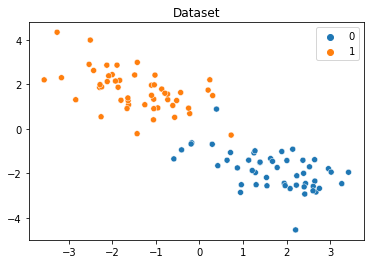

In [94]:
ax = sns.scatterplot(X[:,0],X[:,1],hue=y);
ax.set_title("Dataset");

In [95]:
lr = 0.001
n_iter = 20

sim = [('vanilla', 0.00),
       ('momentum',0.89 )]


init_guess = np.array([-2.86518817,3.3551])  # <== Good to show even close to minimum momentu is still learning 
init_guess = np.array([0.0,0.0]) ## <== Best initialzation to show momentum is fast
#init_guess = np.array([5.0,-1.0])  ## <== also works well


for name, beta in sim:


    theta, history[name] = gradient_descent(X, y,
                                            cost_func_logistic_regression, gradient_logistic_regression,
                                            lr, beta, 
                                            n_iter, init_guess)

    print(f"{name}, beta: {beta}")
    theta0 = history[name]['theta'][0]
    grad0 =  history[name]['grad'][0]
    cost0 = history[name]['cost'][0]

    print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

    it = n_iter -1
    theta = history[name]['theta'][-1]
    grad =  history[name]['grad'][-1]
    cost = history[name]['cost'][-1]

    print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
    
    z = np.matmul(X,theta)  # nx1
    h = 1.0/(1.0 + np.exp(-z))
    y_pred = h > 0.5

    acc = accuracy_score(y, y_pred)
    print(f"accuracy: {acc}")
    
    #print(f"Expected theta:{theta_true}")
    print()

vanilla, beta: 0.0
Initial Guess it: 0 => theta: [0. 0.]; grad: [ 78.07148411 -89.26535366]; cost: 0.69
it: 19 => theta: [-0.57547971  0.69477225]; grad: [ 12.5985412  -16.75125393]; cost: 0.17
accuracy: 0.98

momentum, beta: 0.89
Initial Guess it: 0 => theta: [0. 0.]; grad: [ 78.07148411 -89.26535366]; cost: 0.69
it: 19 => theta: [-1.9491862   2.37439412]; grad: [-0.08236252 -0.33870484]; cost: 0.05
accuracy: 0.98



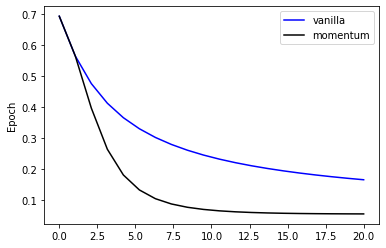

In [96]:
colors = ['b','k','g']

fig,ax = plt.subplots()
for idx, hyper_params in enumerate(sim):
    
    name, beta = hyper_params= hyper_params
    
    cost = history[name]['cost']
    
    m = len(cost)
    x = np.linspace(0,n_iter,m)
    
    _ = ax.plot(x,cost,colors[idx],label=name);
    
#_ = ax.set_ylim([6, 8])
_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();

## Impact of initialization: TODO move this for another notebook

TODO: Review
refs: https://www.deeplearning.ai/ai-notes/initialization/

1. REVIEW and leran more: xavier and he need a deep NN to start make sense and bit random or constant
    1. TODO: Show that xavier is better for sigmoid and softmax and He for ReLu and Linear
1. Constant intialization the DNN will perform very poor <==
1. too-small: leads to gradient vanish
1. too-large: leads too gradients exploding

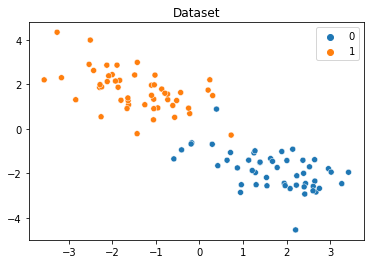

In [97]:
# other options are also available
X, y = make_classification(
    n_samples=100, 
    n_classes=2,
    n_clusters_per_class=1,
    n_features=2,
    n_redundant = 0,
    n_informative = 2,
    n_repeated = 0,
    weights=[0.5,0.5], # balanced classes
    flip_y=0.001, # add noisy the default value for flip_y is 0.1%
    class_sep=1.7, # class_sep is 1.0. The lower the value, the harder classification is.
    random_state=2020) 

ax = sns.scatterplot(X[:,0],X[:,1],hue=y);
ax.set_title("Dataset");

In [98]:
init_guess
n_iter = 50
lr = 0.05



# manual
W00 = tf.constant_initializer(1.0)
b00 = tf.constant_initializer(0.5)
W01 = tf.constant_initializer(-1.0)
b01 = tf.constant_initializer(0.0)

# constant
WB_const = tf.constant_initializer(0.5)

# grad vanish regions
WB_grad_vanish = tf.constant_initializer(5.0)

# Zero
WB0 = tf.constant_initializer(0.0)

# random: uniform
np.random.seed(2021)
W00_rd = tf.constant_initializer(np.random.uniform(-1.0,1.0,1))
b00_rd = tf.constant_initializer(np.random.uniform(-1.0,1.0,1))
W01_rd = tf.constant_initializer(np.random.uniform(-1.0,1.0,1))
b01_rd = tf.constant_initializer(np.random.uniform(-1.0,1.0,1))

# xavier best for sigmoid and softmax
W00_xv = tf.keras.initializers.GlorotNormal(seed=2021)
b00_xv = tf.keras.initializers.GlorotNormal(seed=2020) 
W01_xv = tf.keras.initializers.GlorotNormal(seed=2019)
b01_xv = tf.keras.initializers.GlorotNormal(seed=2018)


# he
W00_he = tf.keras.initializers.HeNormal(seed=2021)
b00_he = tf.keras.initializers.HeNormal(seed=2020) 
W01_he = tf.keras.initializers.HeNormal(seed=2019)
b01_he = tf.keras.initializers.HeNormal(seed=2018)

batch_sizes = [('manual',X.shape[0], (W00,b00,W01,b01)),
               ('const',X.shape[0], (WB_const,WB_const,WB_const,WB_const)),
               ('grad vanish',X.shape[0], (WB_grad_vanish,WB_grad_vanish,WB_grad_vanish,WB_grad_vanish)),
               ('zero',X.shape[0], (WB0,WB0,WB0,WB0)),
               ('random',X.shape[0], (W00_rd,b00_rd,W01_rd,b01_rd)),
               ('xavier',X.shape[0], (W00_xv,b00_xv,W01_xv,b01_xv)),
               ('he',X.shape[0], (W00_he,b00_he,W01_he,b01_he))
              ]

models = {}
for name, bs, initialization in batch_sizes:

    
    W00,b00,W01,b01 = initialization

    print(f"{name}:")
    print(f" ==> Layer 0: {W00((1,1)).numpy()},{b00((1,1)).numpy()}")
    print(f" ==> Layer 1: {W01((1,1)).numpy()},{b01((1,1)).numpy()}")
    
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
    models[name] = tf.keras.Sequential([
                tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=W00,
                          bias_initializer=b00,
                          input_shape=(2,)),
                tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=W01,
                          bias_initializer=b01,
                          input_shape=(1,))
    ])


    sgd = tf.keras.optimizers.SGD(learning_rate=lr, 
                              momentum=0.0,
                              nesterov=False, name='SGD'
                             )

    models[name].compile(loss='mse', optimizer=sgd, metrics=['mse'])

    

    _ = models[name].fit(X, y, epochs=n_iter, batch_size=bs, verbose=0, validation_split=0.0)
    
    
print("Last model summary and config")
models[name].summary()
models[name].optimizer.get_config()



array([0., 0.])

manual:
 ==> Layer 0: [[1.]],[[0.5]]
 ==> Layer 1: [[-1.]],[[0.]]
const:
 ==> Layer 0: [[0.5]],[[0.5]]
 ==> Layer 1: [[0.5]],[[0.5]]
grad vanish:
 ==> Layer 0: [[5.]],[[5.]]
 ==> Layer 1: [[5.]],[[5.]]
zero:
 ==> Layer 0: [[0.]],[[0.]]
 ==> Layer 1: [[0.]],[[0.]]
random:
 ==> Layer 0: [[0.21195656]],[[0.46673872]]
 ==> Layer 1: [[-0.72210569]],[[-0.37465383]]
xavier:
 ==> Layer 0: [[-2.0109973]],[[1.6921577]]
 ==> Layer 1: [[0.5425734]],[[-0.8163171]]
he:
 ==> Layer 0: [[-2.8439798]],[[2.3930724]]
 ==> Layer 1: [[0.7673147]],[[-1.1544467]]
Last model summary and config
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 3         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
____________

{'name': 'SGD',
 'learning_rate': 0.05,
 'decay': 0.0,
 'momentum': 0.0,
 'nesterov': False}

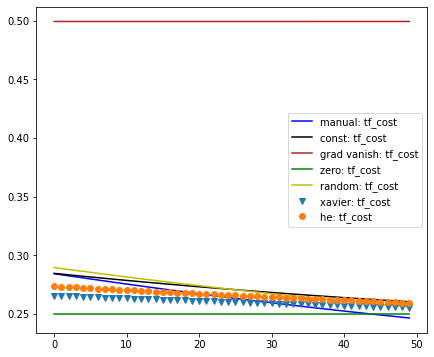

In [99]:
colors = ['b','k','firebrick','g', 'y', 'v', 'o']
fig,ax = plt.subplots(figsize=(7,6))
for idx, sim  in enumerate(batch_sizes): 

    name, bs, initialization = sim 
    tf_cost = models[name].history.history['loss']
    
    _ = ax.plot(range(n_iter),tf_cost,colors[idx],label=f'{name}: tf_cost');

#_ = ax.set_ylim([0, 1])
ax.legend();